In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Sequential
import numpy as np
import tempfile
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [3]:
cwd = "/Workspace/Shared"

# Load data

In [8]:
from tensorflow.keras.applications.densenet import preprocess_input
from glob import glob
img_h = 768
img_w = 1024

filenames = glob(os.path.join(cwd, 'Development_Dataset', 'Training', "Bipbip", "Mais", "Images", "*"))

import random
random.seed(SEED)
random.shuffle(filenames)

training_filenames = filenames[:(int)(0.8*len(filenames))]
validation_filenames = filenames[(int)(0.8*len(filenames)):]

In [7]:
from skimage.transform import resize
from skimage.io import imread
from sklearn.model_selection import train_test_split

X = np.zeros(shape=(len(filenames), img_h , img_w, 3))
Y = np.zeros(shape=(len(filenames), img_h, img_w, 1))

from PIL import Image
def read_rgb_mask(img_path):
        '''
        img_path: path to the mask file
        Returns the numpy array containing target values
        '''

        mask_img = Image.open(img_path)
        mask_img = mask_img.resize([img_w, img_h], resample=Image.NEAREST)
        mask_arr = np.array(mask_img)
        
        new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

        # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
        new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
        new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
        new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
 
        return new_mask_arr
n = 0
for path in filenames:
    img = imread(path)[:,:,:3]
    img = resize(img, (img_h, img_w), mode='constant', preserve_range=True)
    X[n] = preprocess_input(img)
    mask = np.zeros((img_h, img_w, 3), dtype=np.bool)
    mask = read_rgb_mask(path.replace("jpg", "png").replace("Images", "Masks"))
    mask = np.expand_dims(mask, -1)
    mask = np.float32(mask)
    Y[n] = mask
    n = n + 1

x_train = X
y_train = Y
print(x_train.shape)
print(x_train[0].shape)
print(y_train.shape)
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state=SEED)

(90, 768, 1024, 3)
(768, 1024, 3)
(90, 768, 1024, 1)


In [8]:
batch_size = 1

In [8]:
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


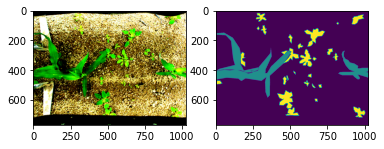

In [9]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_train[30])
ax[1].imshow(y_train[30])

plt.show()

# Compute per-sample class weights

In [14]:
def compute_segmentation_masks_count(img_path):
        '''
        img_path: path to the mask file
        Returns the numpy array containing target values
        '''

        mask_img = Image.open(img_path)
        mask_img = mask_img.resize([img_h, img_w], resample=Image.NEAREST)
        mask_arr = np.array(mask_img)
        
        new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)
    
        # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
        new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
        new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
        new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
        
        unique, counts = np.unique(new_mask_arr, return_counts=True)
        while len(counts) < 3:
            counts = np.append(counts, [1])
        return counts

def compute_weight_unbalance_mean(filenames):
        counts = np.array([0, 0, 0], dtype=np.float64)
        for img_path in filenames:
            count = compute_segmentation_masks_count(img_path.replace("jpg", "png").replace("Images", "Masks"))
            count_norm = count / np.linalg.norm(count)
            count_norm[1] = count_norm[0] / count_norm[1]
            count_norm[2] = count_norm[0] / count_norm[2]
            counts += count_norm
        classes = [0, 1, 2]
        return dict(zip(classes, counts/len(filenames)))
    
def compute_weight_unbalance_matrix(filenames):
        counts = []
        for img_path in filenames:
            count = compute_segmentation_masks_count(img_path.replace("jpg", "png").replace("Images", "Masks"))
            count_norm = count / np.linalg.norm(count)
            count_norm[1] = count_norm[0] / count_norm[1]
            count_norm[2] = count_norm[0] / count_norm[2]
            counts.append(count_norm)
        return np.asarray(counts)
    
class_weights = compute_weight_unbalance_mean(filenames)
sample_weights = compute_weight_unbalance_matrix(filenames)
print(class_weights)
print(np.fromiter(class_weights.values(), dtype=np.float64))
print(sample_weights)
from itertools import cycle
sample_weights_iterator = cycle(sample_weights)

{0: 0.9905849482935153, 1: 12.179596731690367, 2: 68.3102412220077}
[ 0.99058495 12.17959673 68.31024122]
[[9.82198355e-01 1.37413861e+01 5.65403482e+00]
 [9.90833632e-01 7.49260915e+00 3.59198536e+01]
 [9.96036922e-01 1.23016845e+01 2.70615284e+01]
 [9.94790831e-01 1.06410288e+01 2.44788767e+01]
 [9.83610640e-01 1.04647230e+01 6.39255256e+00]
 [9.73072688e-01 1.22723314e+01 4.49598211e+00]
 [9.93387249e-01 8.69329217e+00 8.92028615e+01]
 [9.96963914e-01 1.38441737e+01 3.36641981e+01]
 [9.82393589e-01 1.43194634e+01 5.65340252e+00]
 [9.92086876e-01 9.80503302e+00 1.33458427e+01]
 [9.96453895e-01 1.18431382e+01 1.42382908e+03]
 [9.98088840e-01 1.64611896e+01 8.36622161e+01]
 [9.90825368e-01 7.51961024e+00 3.29737587e+01]
 [9.96671961e-01 1.22508973e+01 1.94108369e+02]
 [9.90487167e-01 7.22893211e+00 7.79421563e+01]
 [9.98624841e-01 2.18205006e+01 3.90507555e+01]
 [9.68492877e-01 5.49110696e+00 5.50836223e+00]
 [9.75534596e-01 5.34584702e+00 7.95682087e+00]
 [9.90344132e-01 7.33660636e+0

# Base model encoder architecture: DenseNet201

In [9]:
model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

#adding dropout and L2 regularization
def add_regularizations(model, dropout_after, regularizer=tf.keras.regularizers.l2(0.01)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
        print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
        return model
    
    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr): #apply also to vgg?
                setattr(layer, attr, regularizer)
                
    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    
    updated_model = Sequential()
    for layer in model.layers:
        updated_model.add(layer)
        if dropout_after in layer.name:
            updated_model.add(Dropout(.2))

    model = updated_model
            
    return model

model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 1024, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 774, 1030, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 384, 512, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 384, 512, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

# Semantic Segmentation final model architecture
## Encoder-Decoder

In [10]:
def create_model(model_input, depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    model.add(model_input)
    
    start_f = 256
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same', kernel_initializer=tf.keras.initializers.GlorotNormal()))
        model.add(tf.keras.layers.LeakyReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    
    return model

In [11]:
model = create_model(model, depth=5, 
                     start_f=8, 
                     num_classes=3)

model = add_regularizations(model, "leaky")
print(model.losses)
model.summary()

[<tf.Tensor: shape=(), dtype=float32, numpy=4.518036>, <tf.Tensor: shape=(), dtype=float32, numpy=1.7096919>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8560739>, <tf.Tensor: shape=(), dtype=float32, numpy=0.4199192>, <tf.Tensor: shape=(), dtype=float32, numpy=0.21531951>, <tf.Tensor: shape=(), dtype=float32, numpy=0.051790856>]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 24, 32, 1920)      18321984  
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 48, 64, 1920)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 64, 256)       4423936   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48, 64, 256)       0         
___________________________________________________

# Prepare the model for training with custom loss

In [14]:
from tensorflow.keras import backend as K
def weightedLoss(originalLossFunc):

    def lossFunc(true, pred):

        axis = -1
        classSelectors = true
        weightsList = next(sample_weights_iterator)
        
        classSelectors = [K.equal(tf.cast(i, tf.float32), classSelectors) for i in range(len(weightsList))]

        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]
        
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]

        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
        # Get prediction and target related to only a single class (i)
        class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
        class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
        intersection = tf.reduce_sum(class_true * class_pred)
        union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
        iou = (intersection + 1e-7) / (union + 1e-7)
        per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=weightedLoss(loss), metrics=metrics)

# Training

In [15]:
callbacks = []

rlp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", min_delta=0.001, patience=3, factor=0.1)
callbacks.append(rlp_callback)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks.append(es_callback)

history = model.fit(x=X_train, y=Y_train,
          epochs=200,
          batch_size=1,
          shuffle=False, #for weighted customized loss
          validation_data=(X_valid, Y_valid), 
          callbacks=callbacks)

Epoch 1/200
72/72 [==============================] - 22s 308ms/step - loss: 7.7238 - accuracy: 0.8997 - meanIoU: 0.3313 - val_loss: 6.3149 - val_accuracy: 0.9357 - val_meanIoU: 0.4853 - lr: 1.0000e-04
Epoch 2/200
72/72 [==============================] - 21s 290ms/step - loss: 5.7583 - accuracy: 0.9409 - meanIoU: 0.5176 - val_loss: 5.1148 - val_accuracy: 0.9530 - val_meanIoU: 0.5786 - lr: 1.0000e-04
Epoch 3/200
72/72 [==============================] - 26s 364ms/step - loss: 4.8625 - accuracy: 0.9508 - meanIoU: 0.5800 - val_loss: 4.4474 - val_accuracy: 0.9568 - val_meanIoU: 0.6166 - lr: 1.0000e-04
Epoch 4/200
72/72 [==============================] - 28s 391ms/step - loss: 4.2747 - accuracy: 0.9562 - meanIoU: 0.6168 - val_loss: 3.9561 - val_accuracy: 0.9583 - val_meanIoU: 0.6170 - lr: 1.0000e-04
Epoch 5/200
72/72 [==============================] - 27s 379ms/step - loss: 3.8131 - accuracy: 0.9596 - meanIoU: 0.6382 - val_loss: 3.5373 - val_accuracy: 0.9607 - val_meanIoU: 0.6242 - lr: 1.0000

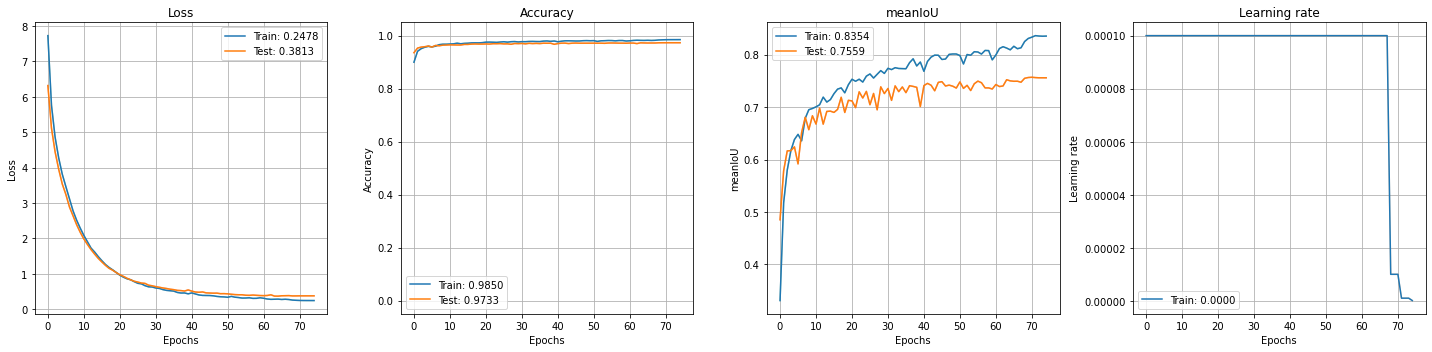

In [16]:
from plot_keras_history import plot_history
plot_history(history.history)

In [18]:
model.save('model_test_new_no_preprocess_fine_tuning_densenet201.h5')

# Testing the model

In [13]:
model = tf.keras.models.load_model("model_test_new_no_preprocess_fine_tuning_densenet201.h5", compile=False)

In [15]:
from tensorflow.keras import backend as K
def weightedLoss(originalLossFunc):

    def lossFunc(true, pred):

        axis = -1
        classSelectors = true
        weightsList = next(sample_weights_iterator)
        
        classSelectors = [K.equal(tf.cast(i, tf.float32), classSelectors) for i in range(len(weightsList))]

        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]
        
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]

        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
        # Get prediction and target related to only a single class (i)
        class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
        class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
        intersection = tf.reduce_sum(class_true * class_pred)
        union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
        iou = (intersection + 1e-7) / (union + 1e-7)
        per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=weightedLoss(loss), metrics=metrics)

In [38]:
from skimage.transform import resize
from skimage.io import imread
from sklearn.model_selection import train_test_split

test_filenames = glob(os.path.join(cwd, 'Development_Dataset', 'Test_Dev', "**", "**", "**", "*"))
X = np.zeros(shape=(len(test_filenames), img_h , img_w, 3))
X_t = np.zeros(shape=(len(test_filenames), img_h , img_w, 3))

from PIL import Image

n = 0
for path in test_filenames:
    img = imread(path)[:,:,:3]
    img = resize(img, (img_h, img_w), mode='constant', preserve_range=True)
    X_t[n] = img
    X[n] = preprocess_input(img)
    n = n + 1
print(X.shape)

(120, 768, 1024, 3)


In [39]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

<tf.Tensor: shape=(1, 1536, 2048, 3), dtype=float32, numpy=
array([[[[8.72004032e-01, 5.12038395e-02, 7.67921656e-02],
         [8.72004032e-01, 5.12038395e-02, 7.67921656e-02],
         [9.68546033e-01, 9.31516197e-03, 2.21387986e-02],
         ...,
         [9.08561528e-01, 3.45341414e-02, 5.69043942e-02],
         [7.54658341e-01, 1.17839530e-01, 1.27502114e-01],
         [7.54658341e-01, 1.17839530e-01, 1.27502114e-01]],

        [[8.72004032e-01, 5.12038395e-02, 7.67921656e-02],
         [8.72004032e-01, 5.12038395e-02, 7.67921656e-02],
         [9.68546033e-01, 9.31516197e-03, 2.21387986e-02],
         ...,
         [9.08561528e-01, 3.45341414e-02, 5.69043942e-02],
         [7.54658341e-01, 1.17839530e-01, 1.27502114e-01],
         [7.54658341e-01, 1.17839530e-01, 1.27502114e-01]],

        [[9.77281153e-01, 1.12597384e-02, 1.14591178e-02],
         [9.77281153e-01, 1.12597384e-02, 1.14591178e-02],
         [9.98743594e-01, 5.40101784e-04, 7.16391543e-04],
         ...,
         

(1, 768, 1024, 3)


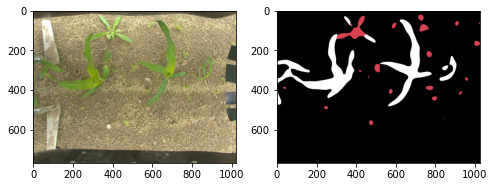

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

image = X[0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))
tf.image.resize(out_sigmoid, [1536, 2048], method='nearest')

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

print(out_sigmoid.shape)

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
prediction_img = np.zeros([out_sigmoid.shape[1], out_sigmoid.shape[2], 3])

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
prediction_img[np.where(predicted_class == 1)] = [255, 255, 255]
prediction_img[np.where(predicted_class == 2)] = [216, 67, 82]
image = X_t[0]
ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(prediction_img))

fig.canvas.draw()

In [44]:
from skimage.transform import resize
from skimage.io import imread
from sklearn.model_selection import train_test_split
from PIL import Image
import json

def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

test_filenames = glob(os.path.join(cwd, 'Development_Dataset', 'Test_Dev', "**", "**", "**", "*"))

submission_dict={}

for path in test_filenames:
    img = imread(path)[:,:,:3]
    img = resize(img, (img_h, img_w), mode='constant', preserve_range=True)
    img = preprocess_input(img)
    
    prediction = model.predict(tf.expand_dims(img, axis=0))
    prediction = tf.image.resize(prediction, [1536, 2048], method='nearest')
    mask_arr = tf.argmax(prediction, -1)[0, ...]
    mask_arr = np.array(mask_arr)
    
    path_metadata = path.split("/")[5:]
    
    team = path_metadata[0]
    crop = path_metadata[1]
    img_name = path_metadata[3].replace(".jpg","").replace(".png","")
    
    submission_dict[img_name] = {}
    submission_dict[img_name]['shape'] = mask_arr.shape
    submission_dict[img_name]['team'] = team
    submission_dict[img_name]['crop'] = crop
    submission_dict[img_name]['segmentation'] = {}

    rle_encoded_crop = rle_encode(mask_arr == 1)
    rle_encoded_weed = rle_encode(mask_arr == 2)

    submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
    submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

print(len(submission_dict))
with open('./predictions/submission.json', 'w') as f:
        json.dump(submission_dict, f)

120
